# GMM applied to a nonlinear regression model 
#### This code estimates the model $$y_t = \theta_1 x_t^{\theta_2} + \varepsilon_t$$ using GMM. We are going to use 3 moments (recall, we could choose any number of moments as long as $N>d=2$), hence GMM is over-identified:

\begin{eqnarray*}
\mathbb{E}[y_t - \theta_1 x_t^{\theta_2}] &=& 0, \\
\mathbb{E}[(y_t - \theta_1 x_t^{\theta_2})x_t] &=& 0, \\
\mathbb{E}[(y_t - \theta_1 x_t^{\theta_2})x^2_t] &=& 0.
\end{eqnarray*}

#### `Note: you have seen the same model estimated by NLS (in the code nls_two_parameters). Comparing the two codes may be instructive about the differences/similarities between the two procedures.` 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from platform import python_version

# The recommended python version is 3.8 or 3.9
print(python_version())
# Adjust the plot size on your computer
plt.rcParams['figure.figsize'] = [7, 7]
# Check current directory
os.getcwd()

3.8.5


'/Users/Fbandi/Dropbox/nonlineareconometrics2024/FEDERICO/Python_codes'

### We are simulating the data. We will set the parameter values as being equal to $(2,2)$ and both $x_t$ and $e_t$ as being normal with certain means and variances. Given the parameter values, $x_t$ and $e_t$, the model will yield $y_t.$ Of course, all quantities can be easily modified. 

In [2]:
# sample size
sample_size = 1000      # Choose the number of observations - You can increase this number to see if the LLN would work

# population parameters
mean_of_x = 20           # mean of the regressor
variance_of_x = 4        # variance of the regressor
variance_of_e = 1000     # variance of the residual

# The parameter values
theta = [2,2] 

# generate x as a sample from the Normal distribution
x = np.random.normal(mean_of_x, np.sqrt(variance_of_x), sample_size)

# generate the residuals as a sample from the Normal distribution
e = np.random.normal(0, np.sqrt(variance_of_e), sample_size)

# generate y using the formula
y =  theta[0]*(x**theta[1]) + e

#The number of moments
N = 3

#The number of parameters
d = 2

### Let us look at the data first. We want to make sure that we have generated enough dispersion (through the variance of the residuals) around the curve. In other words, we do not want all of the observations y and x to exactly sit on a curve. We want the model to be realistic.

Text(0.5, 1.0, 'A scatterplot of the data')

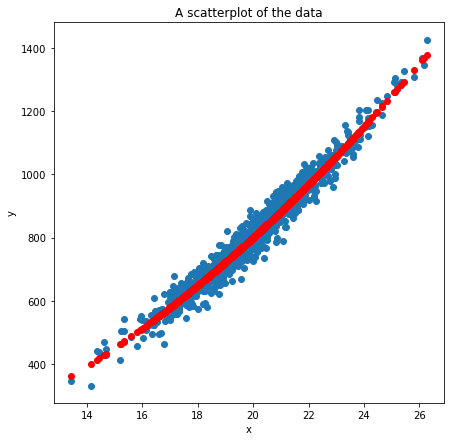

In [3]:
# A scatterplot with matplotlib
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y) 
plt.scatter(x,theta[0]*(x**theta[1]), color = 'red')
plt.title('A scatterplot of the data')

## Now that we have the data, we are ready to begin. Let us go step-by-step.

## (1) We define the GMM criterion in a `Python function` called `gmm`. 

The criterion is:

\begin{eqnarray*}
Q_T(\theta) = \underbrace{g_{T}(\theta )^{\top }}_{1\times 3}\underbrace{W_{T}}_{3\times 3}\underbrace{g_{T}(\theta )}_{3\times1},
\end{eqnarray*}

where

\begin{eqnarray*}
\underbrace{g_T(\theta)}_{3\times1} &=& \frac{1}{T}\sum_{t=1}^{T}\underbrace{g(y_t,x_{t},\theta)}_{3\times1} \\
&=&\frac{1}{T}\sum_{t=1}^{T}\begin{pmatrix} g^{1}(y_t,x_{t},\theta) \\ g^{2}(y_t,x_{t},\theta) \\g^{3}(y_t,x_{t},\theta)  \end{pmatrix} \\
&=& \frac{1}{T}\sum_{t=1}^{T}\begin{pmatrix} y_t - \theta_1 x_t^{\theta_2} \\ (y_t - \theta_1 x_t^{\theta_2})x_t \\ (y_t - \theta_1 x_t^{\theta_2})x^2_t \end{pmatrix} 
\end{eqnarray*}

and $W_T$ is a square symmetric matrix of weights that we choose (see below).

In [4]:
def gmm(parameters, y, x, W, flag):
    
    g = np.zeros([sample_size,N])
    g[:,0] = y - parameters[0]*np.power(x,parameters[1])
    g[:,1] = (y - parameters[0]*np.power(x,parameters[1]))*x
    g[:,2] = (y - parameters[0]*np.power(x,parameters[1]))*x**2
    
    mean_g = np.mean(g,axis=0)
    
    if flag == 1:
        f = mean_g @ W @ mean_g.T
    else:
        f = g
        
    return f

## (2) We find the parameters by `minimizing the GMM criterion`:

\begin{eqnarray*}
\widehat{\theta }_{GMM} &=&\underset{\theta }{\text{ }\arg \min }\left[\underbrace{g_{T}(\theta )^{\top }}_{1\times 3}\underbrace{W_{T}}_{3\times 3}\underbrace{g_{T}(\theta )}_{3\times1}\right] \\
&=&\text{ }\underset{\theta }{\arg \min }\left[\underbrace{Q_{T}(\theta )}_{1\times 1}\right],
\end{eqnarray*}

where $\widehat{\theta}_{GMM} = (\widehat{\theta}_1, \widehat{\theta}_2)$ in our bivariate case. 

### In order to do the minimization we now have to feed the criterion (in the function `gmm` above) into a minimizer (another function which will compute the minimum of the criterion). A possible function is `scipy.optimize.fmin`. 

The inputs of the `scipy.optimize.fmin` function are:

1. `func`. The function to minimize - in our case `gmm` - as defined in the previous snippet.
2. `x0`. The initial guess of the parameters $\theta_1$ and $\theta_2$: `initial_guess`. This is just our initial guess of the parameters for evaluating the function `gmm` at the beginning of the minimization.
3. `args`. The arguments of the `gmm` function that are not paramaters. For our problem, these are the data `cons` and `ret`, respectively.

Additional inputs that are optional:

4. `xtol` and `ftol`. This is the tolerance for the minimizer and the function evaluation, respectively. The algorithm will stop automatically when it cannot find another minimizer that is smaller by at least `xtol` than the current one. Same as for the function evaluation. 
5. `maxiter`. The maximum number of iterations to try. The algorithm stops if it reaches `maxiter` attempts, even if it did not find a minimum.
6. `disp`. A variable indicating whether we want to see some results or not. `disp=0` will not show results, `disp=1` will provide additional information.

# First-stage estimation  

We are going to use the identity matrix as the initial weight matrix: 

\begin{equation*}
\underbrace{W_T}_{3 \times 3} = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}.
\end{equation*}


After obtaining the first-stage GMM estimates, we will calculate the `optimal` weight matrix (using the first-stage estimates) and obtain our `final` second-stage estimates.

In [5]:
# First-stage weigth matrix (the identity matrix)
W = np.eye(N)
                         
# parameters used to initialize the optimization
initial_guess = [4, 5]

# minimize the gmm criterion to find the parameters estimates
estimates = scipy.optimize.fmin(func=gmm, 
                                  x0=initial_guess, 
                                  args=(y, x, W, 1), 
                                  xtol=1e-5, 
                                  ftol=1e-5,
                                  maxiter = 100000,
                                  disp=0)

# The first-stage parameter estimates
print(f'The first-stage estimate of the first parameter is {estimates[0]:.4f}')
print(f'The first-stage estimate of the second parameter is {estimates[1]:.4f}')

The first-stage estimate of the first parameter is 2.0491
The first-stage estimate of the second parameter is 1.9928


# Second-stage estimation

Now that we have the first-stage estimates ($\widehat{\theta}^1_{GMM}$), we will be able to compute the `optimal second-stage estimates` ($\widehat{\theta}^2_{GMM}$) using the `optimal weight matrix` $W_{T}=\widehat{\Phi }_{0}^{-1}$ with

\begin{equation*}
W_{T}=\left( \frac{1}{T}\sum \limits_{t=1}^{T}\left( g(y_t,x_t,\widehat{%
\theta }_{GMM}^{1})g(y_t,x_t,\widehat{\theta }_{GMM}^{1})^{^{\top }}\right)
\right) ^{-1}.
\end{equation*}

In [6]:
###################################################################
# We compute the optimal weight matrix using first-stage estimates
####################################################################

# The pricing errors evaluated at the first-stage estimates
g_opt = gmm(estimates, y, x, W, 2);     

# Phi_hat0 is an average of outer products of pricing errors. We do a loop to compute this average.
Phi_hat0 = np.zeros([N, N])
for j in range(sample_size):
    Phi_hat0 = Phi_hat0 + np.outer(g_opt[j,:], g_opt[j,:]) / sample_size

# The optimal weight matrix is just the inverse of Phi_hat0    
W_opt = np.linalg.inv(Phi_hat0)

In [7]:
#############################
# Second-stage estimation 
#############################

estimates_opt = scipy.optimize.fmin(func=gmm, 
                                    x0=initial_guess, 
                                    args=(y, x, W_opt, 1), 
                                    xtol=1e-5, 
                                    ftol=1e-5, 
                                    disp=0)

# The second-stage parameter estimates
print(f'The second-stage estimate of the first parameter is {estimates_opt[0]:.4f}')
print(f'The second-stage estimate of the second parameter is {estimates_opt[1]:.4f}')

The second-stage estimate of the first parameter is 2.0419
The second-stage estimate of the second parameter is 1.9940


## (3) Finally, we do statistical inference.

When using the `optimal weight matrix,` we know that the GMM estimator is asymptotically normal with a very specific asymptotic variance (the smallest possible):

\begin{equation}
\sqrt{T}(\widehat{\theta}_{GMM} - \theta_0) \overset{d}{\rightarrow}N(0,\mathbb{V})
\end{equation}

with $\mathbb{V} = \left( \Gamma _{0}^{^{\top }}\Phi_{0}^{-1}\Gamma _{0}\right)^{-1}.$ Thus,

\begin{equation*}
\boxed{\mathbb{V}(\widehat{\theta}_{GMM}) = \frac{1}{T}\left( \Gamma _{0}^{^{\top }}\Phi
_{0}^{-1}\Gamma _{0}\right) ^{-1}.}
\end{equation*}

The relevant quantities are $\Phi_0$ and $\Gamma_0$. We begin with $\Phi_0.$ 

\begin{equation*}
\underbrace{\Phi_0}_{3 \times 3}=\mathbb{E}\left(g(y_t,x_{t},\theta _{0})g(y_t,x_{t},\theta _{0})^{\top}\right).
\end{equation*}

This is the expected value of the outer product of the pricing errors: 

\begin{equation*}
\underbrace{\Phi_0}_{3 \times 3} = \mathbb{E}\left( \begin{bmatrix}y_t - \theta_1 x_t^{\theta_2} \\ (y_t - \theta_1 x_t^{\theta_2})x_t \\ (y_t - \theta_1 x_t^{\theta_2})x^2_t \end{bmatrix} \begin{bmatrix} y_t - \theta_1 x_t^{\theta_2} & (y_t - \theta_1 x_t^{\theta_2})x_t & (y_t - \theta_1 x_t^{\theta_2})x^2_t  \end{bmatrix} \right).
\end{equation*}

`Notice that we have already computed this quantity when calculating the optimal weight matrix. We simply have to recompute it using the second-stage (optimal) GMM estimates.` 

As for $\Gamma_0$:

\begin{equation*}
\underbrace{\Gamma_0}_{3 \times 2} = \mathbb{E}\left( \frac{\partial g(y_t, x_{t},\theta _{0})}{\partial \theta ^{\top }}\right).
\end{equation*}

This is a matrix in which every row is a moment and every column is the derivative of the moment with respect to the correspoding parameter. For our problem, we have $N=3$ moments and $d=2$ parameters, thus


\begin{eqnarray*}
\underbrace{\Gamma_{0}}_{3 \times 2} 
  =  \mathbb{E}\left[\begin{array}{cc} -x_t^{\theta_2}& -\theta_1x_t^{\theta_2}\log(x_t)\\
-x_t^{\theta_2+1} & -\theta_1x_t^{\theta_2+1}\log(x_t) \\
-x_t^{\theta_2+2} & -\theta_1x_t^{\theta_2+2}\log(x_t) \\
\end{array}\right].
\end{eqnarray*}

### Estimation of $\widehat{\mathbb{V}}(\widehat{\theta}_{GMM}).$ 

We have:

\begin{equation*}
\boxed{\widehat{\mathbb{V}}(\widehat{\theta}_{GMM}) = \frac{1}{T}\left( \widehat{\Gamma} _{0}^{^{\top }}\widehat{\Phi}
_{0}^{-1}\widehat{\Gamma} _{0}\right) ^{-1}.}
\end{equation*}

The estimates of $\Phi_0$ and $\Gamma_0$ are, respectively:

\begin{equation*}
\widehat{\Phi}_0 = \frac{1}{T}\sum_{t=1}^{T}\left( \begin{bmatrix}y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2} \\ (y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2})x_t \\ (y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2})x^2_t \end{bmatrix} \begin{bmatrix} y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2} & (y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2})x_t & (y_t - \widehat{\theta}_1 x_t^{\widehat{\theta}_2})x^2_t  \end{bmatrix} \right)
\end{equation*}

and

\begin{eqnarray*}
\widehat{\Gamma}_0
  =  \frac{1}{T}\sum_{t=1}^{T}\left[\begin{array}{cc} -x_t^{\widehat{\theta}_2}& -\widehat{\theta}_1x_t^{\widehat{\theta}_2}\log(x_t)\\
-x_t^{\widehat{\theta}_2+1} & -\widehat{\theta}_1x_t^{\widehat{\theta}_2+1}\log(x_t) \\
-x_t^{\widehat{\theta}_2+2} & -\widehat{\theta}_1x_t^{\widehat{\theta}_2+2}\log(x_t) \\
\end{array}\right]
\end{eqnarray*}
Notice that, as always, the expectation was replaced by an arithmetic average over the data and the true parameter value $\theta_0$ was replaced by the second-stage optimal GMM estimates.


In [8]:
#############################
# We begin with Phi_hat0
##############################

# The pricing errors evaluated at the optimal SECOND-STAGE estimates
g_opt = gmm(estimates_opt, y, x, W_opt, 2)

# Phi_hat0 is an average of outer products of pricing errors. We do a loop to compute this average.
Phi_hat0 = np.zeros([N, N])
for j in range(sample_size):
    Phi_hat0 = Phi_hat0 + np.outer(g_opt[j, :], g_opt[j, :]) / sample_size

invPhi_hat0 = np.linalg.inv(Phi_hat0)  # This is the inverse of Phi_hat

#############################
# We now turn to Lambda_hat0
##############################

Lambda_hat0 = np.zeros([N, d])

Lambda_hat0[0, 0] = - np.mean(np.power(x, estimates_opt[1]))
Lambda_hat0[1, 0] = - np.mean(np.power(x, estimates_opt[1]+1))
Lambda_hat0[2, 0] = - np.mean(np.power(x, estimates_opt[1]+2))

Lambda_hat0[0, 1] = - np.mean(estimates_opt[0]*np.power(x, estimates_opt[1])*np.log(x))
Lambda_hat0[1, 1] = - np.mean(estimates_opt[0]*np.power(x, estimates_opt[1]+1)*np.log(x))
Lambda_hat0[2, 1] = - np.mean(estimates_opt[0]*np.power(x, estimates_opt[1]+2)*np.log(x))

################################
# Putting everything together: The estimated variance
################################
                               
# compute the variance-covariance matrix of the parameter estimates
VarCov = (1 / sample_size) * np.linalg.inv(Lambda_hat0.T @ invPhi_hat0 @ Lambda_hat0)


##################################
# Standard errors and t-statistics
###################################

# the variances are on the diagonal
var_diag = np.diag(VarCov)

# Standard errors
std_error = np.sqrt(var_diag)

# t-statistics
t_stats = estimates_opt/std_error     

# table of parameters, standard errors and t statistics
table_estimates = pd.DataFrame({'Stage 1': estimates, 'Stage 2': estimates_opt, 'Std Errors': std_error,
                                't stats': t_stats }, index = ['theta1', 'theta2'])
table_estimates


,Stage 1,Stage 2,Std Errors,t stats
theta1,2.049079,2.041850,0.076045,26.850522
theta2,1.992846,1.994014,0.012269,162.525893
